In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

In [2]:
# Utility functions for the forwardpath
def sigmoid(x): # sigmoid function
    # Numerically stable with large exponentials
    x = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return x

def softmax(x): #softmax function
    # Numerically stable with large exponentials
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    xs = np.sum(x, axis=-1, keepdims=True)
    return x / xs

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


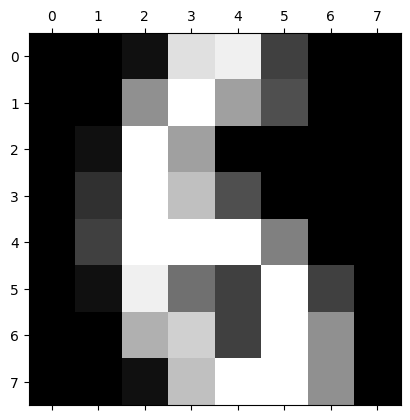

The number is 6


In [3]:
print(digits_df.shape)  # 2D ndarray size of digits_df's shape
print(X_train.shape)    # 2D ndarray size of X_train's shape
print(y_train.shape)    # 2D ndarray size of y_train's shape
print(X_train_org[0])   # print array

idx = np.random.randint(X_train.shape[0])   # print the arbitrary number
dimage = X_train_org[idx].reshape((8,8))
plt.matshow(dimage)
plt.gray()
plt.show()
print('The number is', y_train_num[idx])

In [4]:
class myDenseLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.zeros((n_out, n_in))
        self.bias = np.zeros((n_out))

    def forward(self, x):                      # (b, i)
        ### START CODE HERE ###
        x_lin = (self.wegt @x.T).T + self.bias  # Linear Prediction

        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        ### START CODE HERE ###

        dw = x.T @ x_in   # Gradients for weights
        db = np.sum(x, axis=0)  # Gradients for biases
        wdJdz =  x @ self.wegt # Propagation for lower layer

        ### END CODE HERE ###
        return dw, db, wdJdz

In [5]:
np.random.seed(0)   # set the random seed

tmp = myDenseLayer(3,5)
tmp.wegt = np.random.randn(3,5)
tmp.bias = np.random.randn(3)

print(tmp.forward(np.random.randn(2,5,3))) # print out the result through the forward function.

[[[ 3.23890168  3.05091188 -3.32627831]
  [ 0.388114    3.36724875  1.06158492]
  [ 3.10267869  1.87570497 -1.8326582 ]]

 [[-7.60581826  2.36703751 -1.16423539]
  [ 3.48035012  2.41940644 -0.13917734]
  [ 1.20541315  2.07585619 -1.5435161 ]]]


In [6]:
# activation functions for the backpropagation.
def dJdz_sigmoid(wdJdz_upper, az):
    dJdz = wdJdz_upper * az * (1 - az)    # backpropagation through activation function
    return dJdz

def dJdz_softmax(y_hat, y):
    dJdz = y_hat - y   # backpropagation through activation function
    return dJdz

In [7]:
np.random.seed(0)   # set the random seed

print(dJdz_sigmoid(np.random.randn(3),np.random.randn(3)))  # print out the value through dJdz_sigmoid function.
print(dJdz_softmax(np.random.randn(3),np.random.randn(3)))  # print out the value through dJdz_softmax function.

[-4.90531647 -0.64834065 -1.89126428]
[ 0.53948992 -0.29540078 -1.55749236]


In [8]:
def my_forward(l1, l2, l3, X_in):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))         # first stage forward
    a_2 = sigmoid(l2.forward(a_1))          # second stage forward
    a_3 = softmax(l3.forward(a_2))          # third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(l1, l2, l3, a_1, a_2, a_3, X_in, y_true):
    ### START CODE HERE ###

    # Calculate gradients in reverse order (backpropagation)
    dJdz_3 = dJdz_softmax(a_3, y_true) # define the dJdz_3 value through the dJdz_softmax function.
    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_3, a_2)  # go through 3rd stage backward

    dJdz_2 = dJdz_sigmoid(wdJdz_3, a_2) # define the dJdz_2 value through the dJdz_sigmoid function.
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_2, a_1)   # go through 2nd stage backward

    dJdz_1 = dJdz_sigmoid(wdJdz_2, a_1) # define the dJdz_1 value through the dJdz_sigmoid function.
    dw_1, db_1, _ = l1.backward(dJdz_1, X_in)    # go through 1st stage backward

    ### END CODE HERE ###

    d_1 = [dw_1, db_1]  # assigning values set the data type.
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]

    return d_1, d_2, d_3

def my_loss(l1, l2, l3, X_in, y_true):
    ### START CODE HERE ###

    a_1, a_2, a_3 = my_forward(l1, l2, l3, X_in)    # Assign each returned value to each variable
    loss = -np.mean(np.sum(y_true * np.log(a_3), axis=1))                  # calculate loss

    ### END CODE HERE ###
    return loss

def my_predict(l1, l2, l3, X_in):
    ### START CODE HERE ###
    a_1, a_2, a_3 = my_forward(l1, l2, l3, X_in)    # Assign each returned value to each variable
    pred = np.argmax(a_3, axis=1)                   # make prediction

    ### END CODE HERE ###
    return pred

In [9]:
n_inputs  = 64  # set the parameters
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10

l1 = myDenseLayer(n_hidden1, n_inputs)  # set the layer1 through myDenseLayer function
l2 = myDenseLayer(n_hidden2, n_hidden1) # set the layer2 through myDenseLayer function
l3 = myDenseLayer(n_classes, n_hidden2) # set the layer3 through myDenseLayer function.

print(X_train.shape, y_train.shape) # print out the shape of X_train, y_train
print(l1.wegt.shape, l1.bias.shape) # print out the shape of l1's weight and l1's bias
print(l2.wegt.shape, l2.bias.shape) # print out the shape of l2's weight and l1's bias
print(l3.wegt.shape, l3.bias.shape) # print out the shape of l3's weight and l1's bias

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


In [10]:
# Weights are initialized to...
l1.wegt = np.random.randn(n_hidden1, n_inputs)
l2.wegt = np.random.randn(n_hidden2, n_hidden1)
l3.wegt = np.random.randn(n_classes, n_hidden2)

In [11]:
#set the parameters
alpha = 0.01 # alpha: learning rate
n_epochs = 5000
n_train = X_train.shape[0]

for epoch in range(n_epochs):
    ### START CODE HERE ###

    # Forward Path
    a_1, a_2, a_3 = my_forward(l1, l2, l3, X_train)  # forward path, assuming you have defined my_forward function

    # Backward Path
    d_1, d_2, d_3 = my_backward(l1, l2, l3, a_1, a_2, a_3, X_train, y_train)  # backward path, assuming you have defined my_backward function

    ### END CODE HERE ###

    dw_1, db_1 = d_1
    dw_2, db_2 = d_2
    dw_3, db_3 = d_3

    # Update weights and biases
    ### START CODE HERE ###

    l3.wegt = l3.wegt - alpha * dw_3  # Update weights of layer 3
    l3.bias = l3.bias - alpha * db_3  # Update biases of layer 3
    l2.wegt = l2.wegt - alpha * dw_2  # Update weights of layer 2
    l2.bias = l2.bias - alpha * db_2  # Update biases of layer 2
    l1.wegt = l1.wegt - alpha * dw_1  # Update weights of layer 1
    l1.bias = l1.bias - alpha * db_1  # Update biases of layer 1

    ### END CODE HERE ###

    # Print loss
    if ((epoch+1) % 500 == 0):
        loss_J = my_loss(l1, l2, l3, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))


Epoch:  500,  loss: 0.03927880
Epoch: 1000,  loss: 0.01282518
Epoch: 1500,  loss: 0.00482432
Epoch: 2000,  loss: 0.00283907
Epoch: 2500,  loss: 0.00198707
Epoch: 3000,  loss: 0.00148731
Epoch: 3500,  loss: 0.00113596
Epoch: 4000,  loss: 0.00089513
Epoch: 4500,  loss: 0.00072707
Epoch: 5000,  loss: 0.00060800


In [12]:
from sklearn.metrics import accuracy_score

y_pred = my_predict(l1, l2, l3, X_test)

accuracy_score(y_pred, y_test)  # calculate accuracy with two values

0.9638888888888889

In [13]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)  # calculate accuracy with two values

0.9666666666666667

<Figure size 640x480 with 0 Axes>

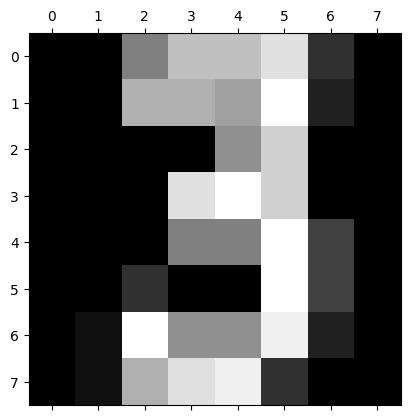

My prediction is 3
sk prediction is 3
Actual number is 3


In [15]:
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)    # expand the dimension to make the input data.

y_pred = my_predict(l1, l2, l3, X_input)    # calculate the prediction value.

s_pred = mlp.predict(X_input)
# print out all the values.
print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))